## Exercício: Modelo de Linguagem com auto-atenção e máscaras causais

Seguimos na mesma linha de treinar um modelo de linguagem a partir dos textos do livro "O Guarani", de José de Alencar.

Neste exercício, vamos treinar um modelo de linguagem com auto-atenção e com máscara causal. A máscara causal é necessária para que o modelo não tenha acesso a palavras futuras, que é a abordagem usada por grandes modelos de linguagem, como o GPT.

Use a implementação matricial de auto-atenção da aula passada.

### Modificações necessárias

* Adicione a máscara causal na função `forward` da cabeça de auto-atenção.
* Modifique o nosso dataloader para retornar inputs (uma lista de tokens de tamanho $n$), targets (uma lista de tokens de tamanho $n$ deslocada para a esquerda em 1 token). Exemplo `input = [1, 2, 3, 4]`, `target = [2, 3, 4, 5]` para a sequência `[1, 2, 3, 4, 5]` com `seq_len=4`, por exemplo (Ver slide 50).

### Extra
* MultiHeadAttention: modifique a cabeça de auto-atenção para ter múltiplas cabeças. Isso não é obrigatório, mas pode ser interessante para ver como o modelo se comporta.
* Diagrama da geração: fazer diagrama que mostre os passos da geração de tokens (conforme slide 47).

### Dicas

* Use como base o vídeo do Karpathy: https://www.youtube.com/watch?v=kCc8FmEb1nY. Observe que, no vídeo, ele primeiro implementa um modelo bi-grama, depois um modelo de linguagem com auto-atenção. O modelo de auto-atenção é implementado por volta do minuto 40, mas vale a pena assistir o vídeo todo.
* Use esta implementação como base: https://colab.research.google.com/drive/1vFTg4MSXVJwNSzPjaCcvmqhxTP7gK7HA?usp=sharing. Observe como o modelo é organizado e como a máscara é implementada na classe MultiHeadAttention.
* Use `context_size=9`

# Bibliotecas e pacotes

In [1]:
import random
import re
import string
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split

In [2]:
random.seed(18)
torch.manual_seed(18)

In [3]:
# Essa flag deve ser utilizada para facilitar a detecção de erros durante a implementação do modelo
# Definir como False sempre e como True apenas para debugging
torch.autograd.set_detect_anomaly(False)

# Hiper-parâmetros

In [4]:
# Tamanho do vocabulario
#   Influencia o pre-processamento de dados e a arquitetura do modelo
vocab_size = 5000


# ID do token desconhecido
#   Influencia o pre-processamento de dados
unknown_token_id = -1


# Tokens reservados
#   Influencia o pre-processamento de dados
n_reserved_tokens = 2
first_token_id = n_reserved_tokens
sos_token_id = 0
eos_token_id = 1


# Tamanho do contexto
#   Influencia a construcao do dataset e a arquitetura do modelo
context_size = 9


# Parametros de arquitetura do modelo
n_heads = 4
d_model = 64
d_ff = 128
p_dropout = 0.10
n_blocks = 4


# Parametros de treinamento do modelo
batch_size = 32
epochs = 10
lr = 5e-4
weight_decay = 1e-4
betas = (0.9, 0.98)
eps = 1e-8

Os parâmetros associados ao otimizador Adam não foram utilizados porque o modelo demonstrou *overfitting* quando utilizado esse otimizador.

# *Download* e carregamento dos textos

Criei uma lista de livros a serem baixados chamada `books` que contém objetos com os campos  `name`, `download_path` e `file_path`.

Para adicionar novos livros ao *dataset*, basta adicionar um livro à lista.


*Obs*: Havia adicionado outros livros de autores clássicos da língua portuguesa para aumentar a quantidade de dados, porém decidi manter apenas obras similares ao Guarany e eram do mesmo autor, o José de Alencar. Os livros que foram excluídos, foram:
```
    create_book_item('Cinco minutos', 'https://www.gutenberg.org/cache/epub/44540/pg44540.txt', 'pg44540.txt'),
    create_book_item('Como e porque sou romancista', 'https://www.gutenberg.org/cache/epub/29040/pg29040.txt', 'pg29040.txt'),

    # Obras do Machado de Assis
    create_book_item('Memorias Posthumas de Braz Cubas', 'https://www.gutenberg.org/cache/epub/54829/pg54829.txt', 'pg54829.txt'),
    create_book_item('Dom Casmurro', 'https://www.gutenberg.org/cache/epub/55752/pg55752.txt', 'pg55752.txt'),
    create_book_item('Quincas Borba', 'https://www.gutenberg.org/cache/epub/55682/pg55682.txt', 'pg55682.txt'),

    # Obras de Camoes
    create_book_item('Os Lusíadas', 'https://www.gutenberg.org/cache/epub/3333/pg3333.txt', 'pg3333.txt')
```



In [5]:
def create_book_item(name, download_path, file_path):
    return {
        "name": name,
        "download_path": download_path,
        "file_path": file_path
    }

In [6]:
books = [
    # Obras do Jose de Alencar
    create_book_item('O Guarany: romance brazileiro, Vol. 1 (of 2)', 'https://www.gutenberg.org/ebooks/67724.txt.utf-8', '67724.txt.utf-8'),
    create_book_item('O Guarany: romance brazileiro, Vol. 2 (of 2)', 'https://www.gutenberg.org/ebooks/67725.txt.utf-8', '67725.txt.utf-8'),
    create_book_item('A Pata da Gazella: romance brasileiro', 'https://www.gutenberg.org/cache/epub/67831/pg67831.txt', 'pg67831.txt'),
    create_book_item('Ubirajara: Lenda Tupi', 'https://www.gutenberg.org/cache/epub/38496/pg38496.txt', 'pg38496.txt'),
    create_book_item('Iracema', 'https://www.gutenberg.org/cache/epub/67740/pg67740.txt', 'pg67740.txt'),
]

books

[{'name': 'O Guarany: romance brazileiro, Vol. 1 (of 2)',
  'download_path': 'https://www.gutenberg.org/ebooks/67724.txt.utf-8',
  'file_path': '67724.txt.utf-8'},
 {'name': 'O Guarany: romance brazileiro, Vol. 2 (of 2)',
  'download_path': 'https://www.gutenberg.org/ebooks/67725.txt.utf-8',
  'file_path': '67725.txt.utf-8'},
 {'name': 'A Pata da Gazella: romance brasileiro',
  'download_path': 'https://www.gutenberg.org/cache/epub/67831/pg67831.txt',
  'file_path': 'pg67831.txt'},
 {'name': 'Ubirajara: Lenda Tupi',
  'download_path': 'https://www.gutenberg.org/cache/epub/38496/pg38496.txt',
  'file_path': 'pg38496.txt'},
 {'name': 'Iracema',
  'download_path': 'https://www.gutenberg.org/cache/epub/67740/pg67740.txt',
  'file_path': 'pg67740.txt'}]

Então, todos os livros são baixados e seus textos são adicionados a uma variável `text`.

In [7]:
text = ''
for book in books:
    !wget {book['download_path']}
    text += open(book['file_path'], encoding="utf-8").read()

--2024-04-04 02:34:54--  https://www.gutenberg.org/ebooks/67724.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/67724/pg67724.txt [following]
--2024-04-04 02:34:54--  http://www.gutenberg.org/cache/epub/67724/pg67724.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/cache/epub/67724/pg67724.txt [following]
--2024-04-04 02:34:54--  https://www.gutenberg.org/cache/epub/67724/pg67724.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372878 (364K) [text/plain]
Saving to: ‘67724.txt.utf-8.6’

67724.txt.utf-8.6   100%[===================>] 3

In [8]:
paragraphs = text.split("\n\n")

clean_paragraph = lambda p: p.replace("\n", " ").strip()
cleaned_paragraphs = [clean_paragraph(paragraph) for paragraph in paragraphs if clean_paragraph(paragraph)]

In [9]:
print(f'Número de parágrafos:\t{len(paragraphs)}')
print(f'Número de parágrafos limpos:\t{len(cleaned_paragraphs)}')

Número de parágrafos:	9121
Número de parágrafos limpos:	8944


In [10]:
print('Amostras de parágrafos coletados')
print('================================')
print()

number_of_paragraphs = 10
sampled_paragraphs = random.sample(cleaned_paragraphs, k=number_of_paragraphs)
for i, paragraph in enumerate(sampled_paragraphs, 1):
    print(f'Parágrafo {str(i).zfill(len(str(number_of_paragraphs)))}')
    print('-------------')
    print(paragraph)
    print()

Amostras de parágrafos coletados

Parágrafo 01
-------------
Elle ignorava que Loredano, com a sua previdencia ordinaria, quando entrara no seu cubiculo para tirar a prancha, tivera o cuidado de passar por um caibro do alpendre, que era de telhavan, a ponta de uma longa corda que cahio sobre a parte de fóra da parede uma braça distante da janella de Cecilia.

Parágrafo 02
-------------
D. Antonio apertou-lhe a mão.

Parágrafo 03
-------------
_Cem dos melhores guerreiros_.--Nesta e outras frazes identicas, os numerais cem ou mil não reprezentam algarismo exato, que não os tinham os tupís para exprimir numero tão elevado. Traduzem apenas esses termos a dezinencia _tiba_, com que os tupís dezignavam cópia e multidão.

Parágrafo 04
-------------
--Mas, papai!.... murmurou a moça.

Parágrafo 05
-------------
A alma nobre do indio prestes a deixar a terra parecia exhalar já do seu involucro; e pousando nos seus labios, nos seus olhos, na sua fronte, esperava o momento de lançar-se no espaço

# Tokenização e definição do vocabulário

O padrão Regex utilizado para tokenização foi inspirado em: https://stackoverflow.com/questions/367155/splitting-a-string-into-words-and-punctuation. O padrão realiza o *match* para:

- `\w+`: palavras;
- `...`: o símbolo de reticências;
- `,`: o símbolo de vírgula;
- `-`: o símbolo de hífen;
- `.`: o símbolo de ponto;
- `?`: o símbolo de interrogação;
- `?`: o símbolo de exclamação;

In [11]:
tokenizer_pattern = r"\w+|\.\.\.|[,-.?!]"

def tokenize_text(text):
    return re.findall(tokenizer_pattern, text.lower(), re.UNICODE)

Então, contaremos a frequência de todos os *tokens* nos textos e selecionamos os `vocab_size` *tokens* mais frequentes.

In [12]:
def count_words(texts):
    word_counts = Counter()
    for text in texts:
        word_counts.update(tokenize_text(text))
    return word_counts

Ordenaremos os `tokens` por frequência e selecionaremos os `vocab_size - n_reserved_tokens` para compor o vocabulário de tamanho `vocab_size`.

In [13]:
word_counts = count_words(cleaned_paragraphs)
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)

In [14]:
print(f'Número de palavras únicas:\t{len(word_counts)}')
print(f'Palavaras mais frequentes:\t{"; ".join(sorted_words[:15])}.')
print(f'Palavaras menos frequentes:\t{"; ".join(sorted_words[-15:])}.')

Número de palavras únicas:	21550
Palavaras mais frequentes:	,; .; -; a; o; de; que; e; se; do; da; um; não; os; uma.
Palavaras menos frequentes:	papeis; reliquias; autobiographicas; reli; estampa; conheci; senões; editar; comparações; desmerecem; corrompida; escoimada; descubram; agosto; 1995.


In [15]:
vocab_words = [word for word, count in word_counts.most_common(vocab_size - n_reserved_tokens)]

In [16]:
print(f'Número de palavras / tokens reservados no vocabulário:\t{len(vocab_words)}')
print(f'Número de palavras / tokens reservados no vocabulário:\t{n_reserved_tokens}')

Número de palavras / tokens reservados no vocabulário:	4998
Número de palavras / tokens reservados no vocabulário:	2


Construímos o vocabulário através dos `tokens` selecionados, adicionando também os `tokens` reservados, como `<EOS>` e `<SOS>`, e cria o vocabulário inverso:

In [17]:
# seleciona tokens mais frequentes
vocab = { word: code for code, word in enumerate(vocab_words, first_token_id) }

# adiciona os tokens reservados
vocab["<SOS>"] = sos_token_id
vocab["<EOS>"] = eos_token_id

# cria vocabulário inverso (token_id -> token)
inverse_vocab = { code: word for word, code in vocab.items() }

In [18]:
print(f'Tamanho esperado do vocabulário:\t{vocab_size}')
print(f'Tamanho resultante do vocabulário:\t{len(vocab)}')

Tamanho esperado do vocabulário:	5000
Tamanho resultante do vocabulário:	5000


A partir do vocabulário e do vocabulário inverso, foram criadas 4 funções para codificação e decodificação de textos:

In [19]:
def encode_token(token):
    return vocab.get(token, unknown_token_id)

def decode_token(code):
    return inverse_vocab.get(code, "<UNK>")

def encode_sentence(sentence):
    return [encode_token(word) for word in tokenize_text(sentence)]

def decode_sentence(encoded_sentence):
    return ' '.join([decode_token(word) for word in encoded_sentence])

Exemplificação da codificação e de decodificação de amostras de parágrafos no conjunto de dados:

In [20]:
print('Exemplo de codificação de um parágrafo:')
print(f'\tTexto original:\t{cleaned_paragraphs[20]}')
print(f'\tTexto codificado:\t{encode_sentence(cleaned_paragraphs[20])}')
print(f'\tTexto decodificado após codificado:\t{decode_sentence(encode_sentence(cleaned_paragraphs[20]))}')

Exemplo de codificação de um parágrafo:
	Texto original:	Publicando este livro em 1857, se disse ser aquella primeira edição uma prova typographica, que algum dia talvez o autor se dispuzesse a rever.
	Texto codificado:	[-1, 136, 997, 21, -1, 2, 10, 58, 103, 272, 255, 2803, 16, 700, -1, 2, 8, 225, 120, 249, 6, 3903, 10, -1, 5, 4916, 3]
	Texto decodificado após codificado:	<UNK> este livro em <UNK> , se disse ser aquella primeira edição uma prova <UNK> , que algum dia talvez o autor se <UNK> a rever .


# Construção do *dataset*

Definição da classe `GuaranyDataset` que deve ser instanciada para cada um dos conjuntos de dados utilizados. Essa classe será utilizada em conjunto com a `DataLoader` do PyTorch.

In [21]:
class GuaranyDataset:
    def __init__(self, data, vocab_size):
        self.X, self.Y = zip(*data)
        self.X = torch.LongTensor(self.X)
        self.Y = torch.LongTensor(self.Y)

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

    def __len__(self):
        return len(self.X)

As amostras do dataset devem ser:
- Input: $\{token_{i}, token_{i+1}, ..., token_{i+context\_size-1} \}$.
- Target: $\{token_{i+1}, token_{i+2}, ..., token_{i+context\_size} \}$

Vale destacar que, foram adicionadas em algumas amostras `tokens` de `<EOS>` e `<SOS>`. O `token` `<EOS>` é adicionado no começo de todo parágrafo e o `token` `<SOS>` é a adicionado no fim de todo parágrafo.

In [22]:
def create_dataset_samples(texts, context_size, encoder):
    encoded_texts = [ [sos_token_id] + encoder(text) + [eos_token_id] for text in texts ]
    samples = []
    for encoded_text in encoded_texts:
        for i in range(len(encoded_text)-context_size-1):
            input = encoded_text[i:i+context_size]
            target = encoded_text[i+1:i+context_size+1]
            if unknown_token_id not in input and unknown_token_id not in target:
                samples.append((input, target))
    return samples

In [23]:
all_samples = create_dataset_samples(
    texts=cleaned_paragraphs,
    context_size=context_size,
    encoder=encode_sentence
)

In [24]:
print(f'Número de amostras no dataset:\t{len(all_samples)}')

print()

sampled_samples = random.sample(all_samples, k=5)
print('Exemplo de amostras codificadas e decodificadas:')
for i, sample in enumerate(sampled_samples, 1):
    print(f'\tAmostra {i}:')
    print(f'\t\tCodificada: {" ".join(str(x) for x in sample[0])} --> {sample[1]}')
    print(f'\t\tDecodificada: {decode_sentence(sample[0])} -> {decode_sentence(sample[1])}')


Número de amostras no dataset:	79617

Exemplo de amostras codificadas e decodificadas:
	Amostra 1:
		Codificada: 5 19 94 23 147 2 840 4 5 --> [19, 94, 23, 147, 2, 840, 4, 5, 738]
		Decodificada: a sua alma no corpo , deixa - a -> sua alma no corpo , deixa - a nesta
	Amostra 2:
		Codificada: 7 4858 2 3783 31 22 160 1066 20 --> [4858, 2, 3783, 31, 22, 160, 1066, 20, 2111]
		Decodificada: de sumê , mandado por seu pai correr as -> sumê , mandado por seu pai correr as terras
	Amostra 3:
		Codificada: 2649 1429 41 3 77 38 13 110 1801 --> [1429, 41, 3, 77, 38, 13, 110, 1801, 9]
		Decodificada: admirar nisto d . antonio era um homem prudente -> nisto d . antonio era um homem prudente e
	Amostra 4:
		Codificada: 6 66 619 2359 16 4693 11 256 12 --> [66, 619, 2359, 16, 4693, 11, 256, 12, 906]
		Decodificada: o indio ouvio cantar uma coruja do lado da -> indio ouvio cantar uma coruja do lado da escada
	Amostra 5:
		Codificada: 386 3338 18 6 128 7 3787 2 9 --> [3338, 18, 6, 128, 7, 3787, 2, 9, 480

A divisão dos dados foi feita em 3 conjuntos:

- Treinamento: 80% dos dados;
- Validação: 10% dos dados;
- Teste: 10% dos dados;

Os conjuntos de treinamento e validação são utilizados durante o treinamento. Os parâmetros do modelo são ajustados apenas considerando o conjunto de treinamento, porém o conjunto de validação é utilizado ao longo desse processo para avaliar se o modelo está sofrendo *overfitting* e a capacidade de generalização do modelo. O conjunto de teste foi utilizado apenas após o treinamento para avaliar o modelo.

In [25]:
raw_train_data, raw_val_data, raw_test_data = random_split(all_samples, [0.8, 0.1, 0.1])

Instanciação dos objetos de *dataset* dos conjuntos de treinamento, validação e teste:

In [26]:
train_data = GuaranyDataset(raw_train_data, vocab_size)
val_data = GuaranyDataset(raw_val_data, vocab_size)
test_data = GuaranyDataset(raw_test_data, vocab_size)

In [27]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

sample = next(iter(train_loader))
inputs, targets = sample

print('Exemplo de batch de dados do conjunto de treinamento:')
print(f'\tShape do tensor inputs:\t{inputs.shape}')
print(f'\tShape do tensor targets:\t{targets.shape}')

Exemplo de batch de dados do conjunto de treinamento:
	Shape do tensor inputs:	torch.Size([32, 9])
	Shape do tensor targets:	torch.Size([32, 9])


# Modelo

#### Positional Encoding

In [28]:
# código inspirado em:
#   https://medium.com/@hunter-j-phillips/positional-encoding-7a93db4109e6
#   https://pytorch.org/tutorials/beginner/transformer_tutorial.html

class PositionalEncoding(nn.Module):
    def __init__(self, context_size, d_model, p_dropout):
        super(PositionalEncoding, self).__init__()

        # cria matriz coluna de posições i
        pos = torch.arange(0, context_size).unsqueeze(1)

        # formula foi traduzida para isso para facilitar a manipulação através de tensores
        # a demonstração pode ser vista no artigo do medium citado acima
        n = 10000.0
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(n) / d_model))

        pe = torch.zeros(context_size, d_model, requires_grad=False)
        pe[:, 0::2] = torch.sin(pos*div_term) # define valor de posições pares como o seno
        pe[:, 1::2] = torch.cos(pos*div_term) # define valor de posições impares como o cosseno

        # adiciona uma dimensão para lidar com batches
        pe = pe.unsqueeze(0)

        # armazena o buffer como parâmetros não-treináveis
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        o = x + self.pe
        o = self.dropout(o)
        return o

#### Auto-atenção multi-cabeça com máscara causal

In [29]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, p_dropout):
        super(MaskedMultiHeadAttention, self).__init__()

        # checa se d_model é divisível por n_heads
        assert d_model % n_heads == 0, "Número de cabeças e dimensão do modelo não são compatíveis!"

        self.n_heads = n_heads

        # pre-calcula o fator de escala sqrt(D/H)
        self.scale_factor = math.sqrt(d_model/n_heads)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(p=p_dropout)

        self.Wq = nn.Parameter(torch.empty(d_model, d_model))
        self.Wk = nn.Parameter(torch.empty(d_model, d_model))
        self.Wv = nn.Parameter(torch.empty(d_model, d_model))
        self.Wo = nn.Parameter(torch.empty(d_model, d_model))
        torch.nn.init.xavier_normal_(self.Wq)
        torch.nn.init.xavier_normal_(self.Wk)
        torch.nn.init.xavier_normal_(self.Wv)
        torch.nn.init.xavier_normal_(self.Wo)


    def forward(self, x):
        # obtem os valores dos tamanhos das dimensoes B (batch_size), L (sequence_length), D (embedding_dim)
        B, L, D = x.size()
        H = self.n_heads
        D_H = int(D/self.n_heads)

        # multiplica o tensor x (shape (B, L, D)) pela matriz Wq (shape (D, D)) e o resultado é Q (shape (B, L, D))
        # depois faz o reshape da matriz Q para suportar H cabeças e Q fica com o shape (B, L, H, D/H)
        # depois transpoe as dimensoes 1 e 2 da matriz Q que fica com o shape (B, H, L, D/H)
        Q = torch.matmul(x, self.Wq)
        Q = Q.reshape(B, L, H, D_H)
        Q = Q.transpose(1, 2)

        # realiza as mesmas transformacoes a construcao da matriz K que no fim fica com o shape (B, H, L, D/H)
        K = torch.matmul(x, self.Wk)
        K = K.reshape(B, L, H, D_H)
        K = K.transpose(1, 2)

        # realiza as mesmas transformacoes a construcao da matriz V que no fim fica com o shape (B, H, L, D/H)
        V = torch.matmul(x, self.Wv)
        V = V.reshape(B, L, H, D_H)
        V = V.transpose(1, 2)


        # multiplica a matriz Q (shape (B, H, L, D/H)) pela matriz K^t (shape (B, H, D/H, L))
        # que resulta na matriz de scores de shape (B, H, L, L)
        scores = torch.matmul(Q, K.transpose(2, 3)) / self.scale_factor

        # cria uma matriz de mascara causal de shape (B, H, L, L) com -inf na parte superior
        mask = torch.triu(torch.full_like(scores, float('-inf')), diagonal=1)

        # calcula os pesos de token em relacao aos outros atraves da matriz scores (shape (B, H, L, L))
        # que é somada a mascara causal (shape (B, H, L, L)), o que resulta na matriz wei de shape (B, H, L, L)
        wei = self.softmax(scores + mask)

        # multiplica a matriz de pesos wei (shape (B, H, L, L)) pela matriz V (shape (B, H, L, D/H))
        # calculando a matriz A (shape (B, H, L, D/H)) dos novos valores após atenção
        A = torch.matmul(wei, V)

        # transpoe as dimensoes 1 e 2 da matriz A para ter novo shape (B, L, H, D/H)
        # depois faz reshape da matriz A para ter novo shape (B, L, D)
        A = A.transpose(1, 2).contiguous()
        A = A.reshape(B, L, D)

        # multiplica a matriz A (shape (B, L, D)) pela matriz Wo (shape (B, D, D)) para
        # calcular a nova matriz de embeddings E (shape (B, L, D))
        E = torch.matmul(A, self.Wo)

        o = self.dropout(E)
        return o

##### Checagem do funcionamento da máscara causal

Foi feita a checagem do resultado da técnica utilizada para aplicar a máscara causal, o que é feito a partir da soma de uma matriz triangular superior (excluindo a diagonal principal) preenchida de valores -inf.

In [30]:
matrix_size = (5, 5)

In [31]:
mask = torch.triu(torch.full(matrix_size, float('-inf')), diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [32]:
random_embedding = torch.rand(matrix_size)
random_embedding

tensor([[0.8368, 0.4554, 0.6615, 0.5423, 0.4531],
        [0.6140, 0.6742, 0.5231, 0.2560, 0.3687],
        [0.0372, 0.0768, 0.3777, 0.3506, 0.9400],
        [0.3407, 0.8333, 0.4857, 0.7290, 0.0515],
        [0.1239, 0.8656, 0.0996, 0.1233, 0.3045]])

In [33]:
random_embedding + mask

tensor([[0.8368,   -inf,   -inf,   -inf,   -inf],
        [0.6140, 0.6742,   -inf,   -inf,   -inf],
        [0.0372, 0.0768, 0.3777,   -inf,   -inf],
        [0.3407, 0.8333, 0.4857, 0.7290,   -inf],
        [0.1239, 0.8656, 0.0996, 0.1233, 0.3045]])

In [34]:
F.softmax(random_embedding+mask, dim=-1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4850, 0.5150, 0.0000, 0.0000, 0.0000],
        [0.2902, 0.3019, 0.4079, 0.0000, 0.0000],
        [0.1899, 0.3107, 0.2195, 0.2799, 0.0000],
        [0.1594, 0.3347, 0.1556, 0.1593, 0.1910]])

##### Comparação entre MaskedMultiHeadAttention e nn.MultiheadAttention

In [35]:
mask = torch.triu(torch.full((context_size, context_size), float('-inf')), diagonal=1)

In [36]:
# cria "embedding" aleatorio de shape para um batch de contextos
random_embedding = torch.rand(batch_size, context_size, d_model)
random_embedding.size()

torch.Size([32, 9, 64])

In [37]:
masked_attention = MaskedMultiHeadAttention(
    n_heads=n_heads,
    d_model=d_model,
    p_dropout=p_dropout,
).eval()

pytorch_attention = torch.nn.MultiheadAttention(
    d_model,
    num_heads=n_heads,
    dropout=p_dropout,
    bias=False,
    batch_first=True
).eval()

In [38]:
pytorch_attention.in_proj_weight = torch.nn.Parameter(
    torch.concat((
        masked_attention.Wq.transpose(0, 1),
        masked_attention.Wk.transpose(0, 1),
        masked_attention.Wv.transpose(0, 1),
    ))
)

pytorch_attention.out_proj.weight = nn.Parameter(masked_attention.Wo.transpose(0, 1))

In [39]:
output_masked_att  = masked_attention(random_embedding).detach()

output_pytorch_att, _ = pytorch_attention(
    random_embedding,
    random_embedding,
    random_embedding,
    attn_mask=mask,
    need_weights=False,
    is_causal=True,
)
# output_pytorch_att, _ = pytorch_attention(random_embedding, random_embedding, random_embedding, need_weights=False)
output_pytorch_att = output_pytorch_att.detach()

In [40]:
assert output_masked_att.shape == output_pytorch_att.shape, f"MaskedMultiHeadAttention e nn.MultiheadAttention com máscara causal resultam em tensores com shapes diferentes! Shape do MaskedMultiHeadAttention: {output_masked_att.shape}. Shape do nn.MultiheadAttention: {output_pytorch_att.shape}."
print('MaskedMultiHeadAttention e nn.MultiheadAttention com máscara causal resultam em tensores com shapes iguais!')

MaskedMultiHeadAttention e nn.MultiheadAttention com máscara causal resultam em tensores com shapes iguais!


In [41]:
decimals = 6

np.testing.assert_array_almost_equal(output_masked_att, output_pytorch_att, decimal=decimals)
print(f'MaskedMultiHeadAttention e nn.MultiheadAttention com máscara causal resultam em tensores iguais até {decimals} casas decimais!')

MaskedMultiHeadAttention e nn.MultiheadAttention com máscara causal resultam em tensores iguais até 6 casas decimais!


#### Feed-Forward Network (2-Layer MLP)

In [42]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_hidden, p_dropout):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(d_model, d_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_hidden, d_model)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        # na camada fc1, a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, FF)
        o = self.fc1(x)

        o = self.relu(o)

        # na camada fc2, a entrada possui um shape (B, L, FF) e a saída possui um shape (B, L, D)
        o = self.fc2(o)

        o = self.dropout(o)
        return o

## Language Model: PositionalEncoding + Auto-Atenção + FNN + Linear Output Layer

In [43]:
import torch.nn as nn

class TransformerDecoderBlock(nn.Module):
    def __init__(
        self,
        context_size,
        n_heads,
        d_model,
        p_dropout
    ):
        super(TransformerDecoderBlock, self).__init__()
        self.attention = MaskedMultiHeadAttention(n_heads, d_model, p_dropout)
        self.fnn = FeedForwardNetwork(d_model, d_ff, p_dropout)
        self.ln1 = nn.LayerNorm((context_size, d_model))
        self.ln2 = nn.LayerNorm((context_size, d_model))


    def forward(self, x):
        # na primeira sublayer, composta de auto-atencao + residual connection + layer normalization,
        # a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, D)
        o = self.ln1(x + self.attention(x))

        # na segunda sublayer, composta de uma feed-forward network (ou mlp) + residual connection + layer normalization,
        # a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, D)
        o = self.ln2(o + self.fnn(o))

        return o

In [44]:
import torch.nn as nn

class LanguageModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        context_size,
        d_model,
        d_ff,
        p_dropout,
        n_blocks,
    ):
        super(LanguageModel, self).__init__()
        self.inputs_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)
        self.positional_enc = PositionalEncoding(context_size, d_model, p_dropout)
        self.transfomer_blocks = nn.Sequential(*[TransformerDecoderBlock(context_size, n_heads, d_model, p_dropout) for _ in range(n_blocks)])
        self.fc_out = nn.Linear(d_model, vocab_size)


    def forward(self, x):
        # se não está usando batch, adiciona uma dimensão
        if x.dim() == 1:
            x = x.unsqueeze(0)

        # na camada inputs_emb, a entrada possui um shape (B, L) e a saída possui um shape (B, L, D)
        o = self.inputs_emb(x)

        # na camada positional_enc, a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, D)
        o = self.positional_enc(o)

        # na sequencia de camadas transfomer_blocks, a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, D)
        o = self.transfomer_blocks(o)

        # na camada fc_out, a entrada possui um shape (B, L, D) e a saída possui um shape (B, L, V)
        o = self.fc_out(o)
        return o

#### Análise e verificação: instanciação, número de parâmetros e forward pass

Foi construído um modelo baseado na arquitetura Decoder-only de Transformers, contendo uma quantidade de `n_blocks`, sendo todos os blocos com `n_heads`.

In [45]:
model = LanguageModel(
    vocab_size,
    context_size,
    d_model,
    d_ff,
    p_dropout,
    n_blocks
)

In [46]:
print(' Parâmetros do modelo ')
print('======================')
for parameter in model.named_parameters():
    print(f'Parâmetros "{parameter[0]}":')
    print(f'\tShape: {parameter[1].shape};\tTipo: {parameter[1].dtype};\tDevice: {parameter[1].device};\tTreinavel: {parameter[1].requires_grad};')
print('======================')

print()

print(f'Número de parâmetros: \t {sum(p.numel() for p in model.parameters())}')
print(f'Número de parâmetros treináveis: \t {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

 Parâmetros do modelo 
Parâmetros "inputs_emb.weight":
	Shape: torch.Size([5000, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "transfomer_blocks.0.attention.Wq":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "transfomer_blocks.0.attention.Wk":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "transfomer_blocks.0.attention.Wv":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "transfomer_blocks.0.attention.Wo":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "transfomer_blocks.0.fnn.fc1.weight":
	Shape: torch.Size([128, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "transfomer_blocks.0.fnn.fc1.bias":
	Shape: torch.Size([128]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetros "transfomer_blocks.0.fnn.fc2.weight":
	Shape: torch.Size([64, 128]);	Tipo: torch.fl

In [47]:
sample = next(iter(train_loader))
inputs, targets = sample

outputs = model(inputs)

print(f'Shape dos inputs:\t{inputs.size()}')
print(f'Shape dos targets:\t{targets.size()}')
print(f'Shape dos outputs:\t{outputs.size()}')

Shape dos inputs:	torch.Size([32, 9])
Shape dos targets:	torch.Size([32, 9])
Shape dos outputs:	torch.Size([32, 9, 5000])


# Treinamento

Analisando como o cálculo da *loss* ocorre para cada *batch*, temos:

In [48]:
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

In [49]:
sample = next(iter(train_loader))
inputs, targets = sample
outputs = model(inputs)

In [50]:
print(f'Shape dos targets originais:\t{targets.size()}')
print(f'Shape dos outputs originais:\t{outputs.size()}')

Shape dos targets originais:	torch.Size([2, 9])
Shape dos outputs originais:	torch.Size([2, 9, 5000])


In [51]:
print(f'Shape dos targets achatados:\t{targets.view(-1).size()}')
print(f'Shape dos outputs achatados:\t{outputs.view(-1, vocab_size).size()}')

Shape dos targets achatados:	torch.Size([18])
Shape dos outputs achatados:	torch.Size([18, 5000])


In [52]:
targets = targets.view(-1)
targets

tensor([ 369,  277,  996,  593,  735,  187, 4624,   35, 4625,    5,  155,  258,
         308, 1062,    2,   58,    6,  133])

In [53]:
outputs = outputs.view(-1, vocab_size)
outputs

tensor([[ 0.3608, -0.8997, -0.8800,  ...,  0.0401, -1.3605,  0.1357],
        [ 0.6326, -0.2115, -0.9612,  ..., -0.2220, -0.8229, -0.3644],
        [ 0.4280, -0.5725, -0.4472,  ..., -0.1706, -0.9194, -0.3822],
        ...,
        [ 0.3005, -0.1720, -0.6093,  ..., -0.4235, -1.4517,  0.4871],
        [-0.3315, -0.3259, -0.0949,  ..., -0.0201, -0.7043,  0.3502],
        [-0.0838, -0.1171, -0.3103,  ..., -0.1108, -0.9838,  0.7249]],
       grad_fn=<ViewBackward0>)

In [54]:
criterion = nn.CrossEntropyLoss()

loss = criterion(outputs, targets)
ppl = torch.exp(loss)

print(f'Loss:\t{loss.item()}')
print(f'PPL:\t{ppl.item()}')

Loss:	8.836387634277344
PPL:	6880.09423828125


O modelo foi treinado avaliando, a cada época, a Cross Entropy e a Perplexidade no conjunto de treinamento e de validação.

In [55]:
def calculate_loss(criterion, outputs, targets):
    outputs = outputs.view(-1, vocab_size)
    targets = targets.view(-1)
    loss = criterion(outputs, targets)
    return loss

In [56]:
def eval_model_on_data(model, data_loader, device):
    criterion = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        loss_sum = 0.0
        total = 0
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss_sum += calculate_loss(criterion, outputs, targets) * targets.numel()
            total += targets.numel()
    loss = loss_sum / total
    ppl = torch.exp(loss)

    return loss.item(), ppl.item()

In [57]:
def add_step_on_hist(hist, train_loss, train_ppl, val_loss, val_ppl):
    hist["loss_train"].append(train_loss)
    hist["ppl_train"].append(train_ppl)
    hist["loss_val"].append(val_loss)
    hist["ppl_val"].append(val_ppl)

In [58]:
# Inicializa os dataloaders de treinamento e de validação
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


# Inicializa o histórico do treinamento do modelo
hist = {
    "loss_train": [],
    "loss_val": [],
    "ppl_train": [],
    "ppl_val": [],
}


# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f'Utilizando o device {device} para realizar o processamento.')
print()


# Avalia a loss e a perplexidade antes do treinamento
initial_train_loss, initial_train_ppl = eval_model_on_data(model, train_loader, device)
initial_val_loss, initial_val_ppl = eval_model_on_data(model, val_loader, device)
add_step_on_hist(hist, initial_train_loss, initial_train_ppl, initial_val_loss, initial_val_ppl)

print('Avaliação inicial no conjunto de treinamento:')
print('---------------------------------------------')
print(f'\tLoss:\t{initial_train_loss:.4f}')
print(f'\tPPL:\t{initial_train_ppl:.4f}')
print()
print('Avaliação inicial no conjunto de validação:')
print('-------------------------------------------')
print(f'\tLoss:\t{initial_val_loss:.4f}')
print(f'\tPPL:\t{initial_val_ppl:.4f}')
print()
print('Treinamento:')
print('------------')


# Define loss and otimizador
criterion = nn.CrossEntropyLoss()

# Otimizador AdamW
optimizer = optim.AdamW(
    model.parameters(),
    lr=lr,
    betas=betas,
    eps=eps,
    weight_decay=weight_decay,
)


# Laço de treinamento
for epoch in range(epochs):
    # Tempo de inicio da epoca
    start_time = time.time()

    # Acumuladores para calculo da loss no conjunto de treinamento
    train_loss_sum = 0.0
    total = 0

    # Laço da época
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = calculate_loss(criterion, outputs, targets)

        # Backward and otimizacao
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Incremento da loss
        train_loss_sum += loss * targets.numel()
        total += targets.numel()

    # Calculo da loss e da ppl da época no conjunto de treinamento e de validação
    train_loss = train_loss_sum/total
    train_ppl = torch.exp(train_loss)
    val_loss, val_ppl = eval_model_on_data(model, val_loader, device)
    add_step_on_hist(hist, train_loss.item(), train_ppl.item(), val_loss, val_ppl)

    # Tempo de fim da epoca
    end_time = time.time()

    # Tempo de duracao da epoca
    epoch_duration = end_time - start_time

    print(f'Época [{str(epoch+1).zfill(len(str(epochs)))}/{epochs}], \
            Loss no treinamento: {train_loss.item():.4f}, \
            PPL no treinamento: {train_ppl.item():.4f}, \
            Loss na validação: {val_loss:.4f}, \
            PPL na validação: {val_ppl:.4f}, \
            Tempo passado: {epoch_duration:.2f} sec')

Utilizando o device cuda para realizar o processamento.

Avaliação inicial no conjunto de treinamento:
---------------------------------------------
	Loss:	8.7132
	PPL:	6082.5117

Avaliação inicial no conjunto de validação:
-------------------------------------------
	Loss:	8.7099
	PPL:	6062.3926

Treinamento:
------------
Época [01/10],             Loss no treinamento: 5.5032,             PPL no treinamento: 245.4676,             Loss na validação: 4.4657,             PPL na validação: 86.9837,             Tempo passado: 24.63 sec
Época [02/10],             Loss no treinamento: 4.2383,             PPL no treinamento: 69.2868,             Loss na validação: 3.6922,             PPL na validação: 40.1349,             Tempo passado: 24.49 sec
Época [03/10],             Loss no treinamento: 3.6989,             PPL no treinamento: 40.4032,             Loss na validação: 3.2622,             PPL na validação: 26.1072,             Tempo passado: 24.19 sec
Época [04/10],             Loss no tre

In [59]:
# Transforma as listas do histórico em np.array
for key in hist:
    hist[key] = np.array(hist[key])

Podemos analisar o gráfico do histórico da *loss*, em épocas, conforme o treinamento ocorreu:

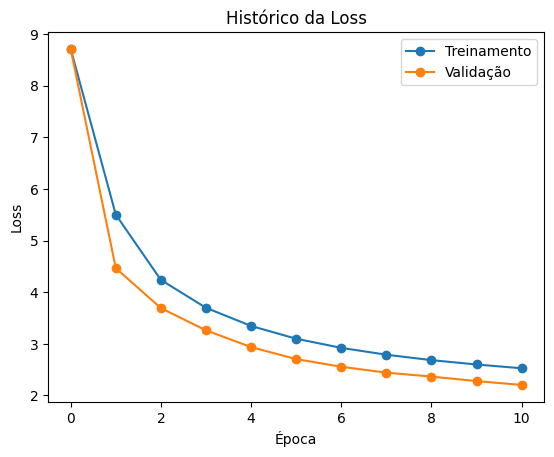

In [60]:
plt.plot(hist["loss_train"], "o-")
plt.plot(hist["loss_val"], "o-")

plt.legend(["Treinamento", "Validação"])
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Histórico da Loss")

plt.show()

Podemos analisar o gráfico do histórico da *perplexidade*, em épocas, conforme o treinamento ocorreu:

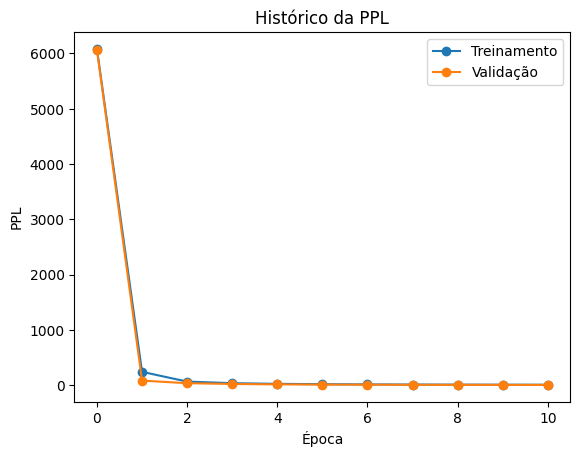

In [61]:
plt.plot(hist["ppl_train"], "o-")
plt.plot(hist["ppl_val"], "o-")

plt.legend(["Treinamento", "Validação"])
plt.xlabel("Época")
plt.ylabel("PPL")
plt.title("Histórico da PPL")

plt.show()

# Avaliação

In [62]:
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [63]:
# Avalia modelo treinado nos dados de teste

loss, ppl = eval_model_on_data(model, test_loader, device)

print('Avaliação no conjunto de teste:')
print('---------------------------')
print(f'\tLoss:\t{loss:.4f}')
print(f'\tPPL:\t{ppl:.4f}')

Avaliação no conjunto de teste:
---------------------------
	Loss:	2.2106
	PPL:	9.1212


# Síntese de texto

Para síntese do texto, foram criadas duas funções:

- `generate_next_token`: Gera o próximo `token` a partir de um contexto. Esse método não aceita contextos que possuam `tokens` fora do vocabulário;

- `generate_text`: Gera a continuação de um texto passado, interrompendo a geração caso o modelo gere o `token` `<EOS>` (*end-of-sentence*) ou o texto continuado ultrapasse de um número máximo de `tokens` `max_length`. Este método não aceita que seja passado um texto a ser continuado com `tokens` fora do vocabulário ou com uma quantidade de `tokens` menor do que o `context_size`.

In [64]:
def generate_next_token(model, context, device, use_multinomial=False):
    # Verifica se o contexto é válido
    assert unknown_token_id not in context, f'Contexto "{text}" possui um token não que não está no vocabulário! Contexto codificado: {" ".join(str(x) for x in context)}'

    # Faz a predicao
    input = torch.LongTensor(context).to(device)
    output = model(input)

    # Remove dimensao do batch
    output = output.squeeze(dim=0)

    # Armazena as probabilidades do último token
    probs = F.softmax(output[-1], dim=-1)

    # Escolhe o próximo token considerando a flag use_multinomial
    if use_multinomial == True:
        next_token = torch.multinomial(probs, num_samples=1).item()
    else:
        next_token = probs.argmax().item()

    return next_token


In [65]:
def generate_text(model, text, max_length, device, use_multinomial=True, verbose=False):
    # Codifica sequência e verifica se possui tamanho válido
    encoded_text = encode_sentence(text)
    assert len(encoded_text) >= context_size, f'Texto "{text}" possui tamanho menor do que o context_size = {context_size}. Tamanho do texto: {len(encoded_text)}.'

    # Configura modelo para avaliação
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        # Inicia com o token <SOS> (start of sentence)
        next_token = sos_token_id

        # Gera novos tokens até chegar ao max_length or gerar <EOS> (end of sentence)
        while len(encoded_text) < max_length and not next_token == eos_token_id:
            # Preve o próximo token
            context = encoded_text[-context_size:]
            next_token = generate_next_token(model, context, device, use_multinomial)

            # Se não for o token <EOS>, adiciona ao texto gerado
            if not next_token == eos_token_id:
                encoded_text.append(next_token)
                if verbose:
                    print(f'Texto predito:\t{decode_sentence(encoded_text)}')

        if verbose:
            if next_token == eos_token_id:
                print(f'O texto foi finalizado porque o modelo gerou <EOS>.')
            else:
                print(f'O texto foi finalizado porque chegou ao contexto de tamanho máximo.')

    return decode_sentence(encoded_text)

In [66]:
text = "Foi assim que a nossa amiga, pouco a pouco, "

In [67]:
generate_text(model, text, max_length=20, device=device, use_multinomial=True, verbose=True)

Texto predito:	foi assim que a nossa amiga , pouco a pouco , o
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o italiano
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o italiano da
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o italiano da tribu
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o italiano da tribu .
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o italiano da tribu . sómente
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o italiano da tribu . sómente já
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o italiano da tribu . sómente já tão
Texto predito:	foi assim que a nossa amiga , pouco a pouco , o italiano da tribu . sómente já tão e
O texto foi finalizado porque chegou ao contexto de tamanho máximo.


'foi assim que a nossa amiga , pouco a pouco , o italiano da tribu . sómente já tão e'

In [68]:
gen_text = generate_text(model, text, max_length=20, device=device, use_multinomial=True, verbose=True)
print(f'O texto gerado utilizando o multinomial foi:\n\t{gen_text}')

Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery traga
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery traga que
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery traga que seja
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery traga que seja quando
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery traga que seja quando quereis
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery traga que seja quando quereis tenho
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery traga que seja quando quereis tenho com
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery traga que seja quando quereis tenho com a
O texto foi finalizado porque chegou ao contexto de tamanho máximo.
O texto gerado utilizando o multinomial foi:
	foi assim que a nossa amiga , pouco a pouco , pery traga que seja quando quereis tenho com 

In [69]:
gen_text = generate_text(model, text, max_length=20, device=device, use_multinomial=False, verbose=True)
print(f'O texto gerado utilizando o argmax foi:\n\t{gen_text}')

Texto predito:	foi assim que a nossa amiga , pouco a pouco , que
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que o
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que o indio
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que o indio ,
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que o indio , o
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que o indio , o indio
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que o indio , o indio ,
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que o indio , o indio , que
Texto predito:	foi assim que a nossa amiga , pouco a pouco , que o indio , o indio , que o
O texto foi finalizado porque chegou ao contexto de tamanho máximo.
O texto gerado utilizando o argmax foi:
	foi assim que a nossa amiga , pouco a pouco , que o indio , o indio , que o


In [70]:
gen_text = generate_text(model, text, max_length=80, device=device, use_multinomial=True, verbose=True)
print(f'O texto gerado utilizando o multinomial foi:\n\t{gen_text}')

Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery ,
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro seu
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro seu filho
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro seu filho não
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro seu filho não era
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro seu filho não era o
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro seu filho não era o middle
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro seu filho não era o middle branco
Texto predito:	foi assim que a nossa amiga , pouco a pouco , pery , guerreiro seu filho não era o middle branco ,
T

É possível notar que o modelo foi capaz de gerar textos muito mais coerentes, dentro do possível, se comparado aos modelos anteriores.

Porém, é possível notar que, apesar de ser treinado com `tokens` `<EOS>` nas amostras dos dados de treinamento, o modelo não gerou esse `token` nos exemplos sintetizados. Isso pode ter ocorrido devido ao fato de que poucos desses `tokens` ocorriam no conjunto de dados, já que só foram inseridos ao fim de cada parágrafos.